# Mask RCNN implementation
Mask RCNN implementation can be found here: https://github.com/matterport/Mask_RCNN

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# COCO related libraries
from pycocotools.coco import COCO

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as ET
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.model import load_image_gt

### Constants

In [ ]:
# The number of unique objects you are detecting
NUM_OBJECTS = 1

### Classes

In [5]:
#https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py
class ImageConfig(Config):
    """ Training configuration """
    NAME = "image_cfg"
    
    # Number of class (background + object1)
    NUM_CLASSES = 1 + NUM_OBJECTS
    # Number of training steps per epoch - similar to batch size
    STEPS_PER_EPOCH = 50
    # simplify GPU config
    # Batch size is 1 (GPUs * images/GPU). - might be able to put up to 8 images on 1 gpu
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [6]:
class PredictionConfig(Config):
    """ Prediction configuration"""
    # define the name of the configuration
    NAME = "image_cfg"
    # number of classes (background + object)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [7]:
class ImageDataset(Dataset):
    """ Required Dataset Class for Mask RCNN """
    
    def load_dataset(self, dataset_dir, is_train=True):
        """ Load the dataset definitions """
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # loop through images in directory
        for filename in os.listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):
        """ Extract bounding boxes from an annotation file """ 
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height


    def load_mask(self, image_id):
        """ Load the masks for an image 
    
            A mask is a binary image.
            0's where the object isn't and 
            1's where the object is using the boundary boxes.
        """
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, np.asarray(class_ids, dtype='int32')

   
    def image_reference(self, image_id):
        """ Load an image reference - returns path of image """
        info = self.image_info[image_id]
        return info['path']

### Functions

In [8]:
def evaluate_model(dataset, model, cfg):
    """ Calculate the mAP for a model on a given dataset """
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

In [9]:
def extract_boxes(filename):
    """ Function to extract bounding boxes from an annotation file """
    # load and parse the file
    tree = ET.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

In [31]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    """ Plot a number of photos with ground truth and predictions """
    
    plt.figure(figsize=(plot_size * 2, plot_size * n_images))
    
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

### Load and Parse XML File

In [11]:
filename = "Mask_RCNN/kangaroo/annots/00001.xml"
boxes, width, height = extract_boxes(filename)

In [12]:
print(boxes)
print(width)
print(height)

[[233, 89, 386, 262], [134, 105, 341, 253]]
450
319


In [13]:
# Train set
train_set = ImageDataset()
train_set.load_dataset('Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Test/val set
test_set = ImageDataset()
test_set.load_dataset('Mask_RCNN/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


### Test Images and Masks can be loaded

In [14]:
# Load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# Load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
#mask.shape[2] => how many bounding boxes

(338, 600, 3)
(338, 600, 2)


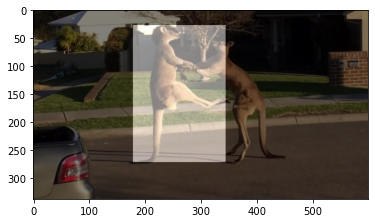

In [15]:
# Plot image
plt.imshow(image)
# Plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5) # alpha => how dominant the image is
plt.show()

### Plot 9 Random Images

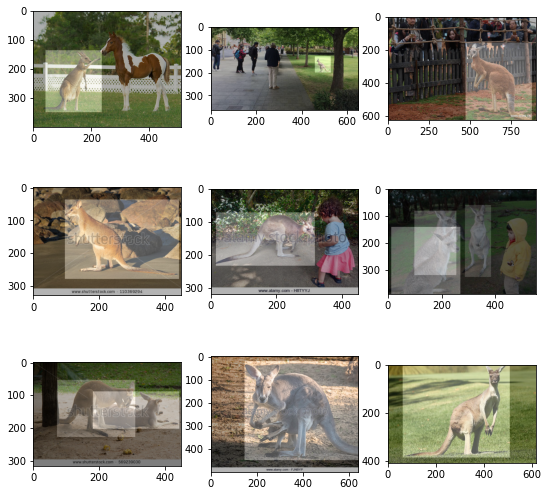

In [16]:
rows = 3
cols = 3
plot_size = 3

indices = np.random.choice(np.arange(len(train_set.image_ids)), rows * cols)
plt.figure(figsize=(plot_size * cols, plot_size * rows))
for i in range(rows*cols):
    index = indices[i]
    
    # define subplot
    plt.subplot(rows, cols, i + 1)
    # plot raw pixel data
    image = train_set.load_image(index)
    plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(index)
    # Loop through all masks in image
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

plt.show()

In [17]:
# Run through image_info to make sure they are loaded properly
#for image_id in train_set.image_ids:
for i in range(10): #first 10 image_info's
    image_id = train_set.image_ids[i]
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info)

{'id': '00039', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00039.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00039.xml'}
{'id': '00062', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00062.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00062.xml'}
{'id': '00144', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00144.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00144.xml'}
{'id': '00107', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00107.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00107.xml'}
{'id': '00066', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00066.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00066.xml'}
{'id': '00007', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00007.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00007.xml'}
{'id': '00016', 'source': 'dataset', 'path': 'Mask_RCNN/kangaroo/images/00016.jpg', 'annotation': 'Mask_RCNN/kangaroo/annots/00016.xml'}
{'id': '00027', 'source': 'dataset', 'pat

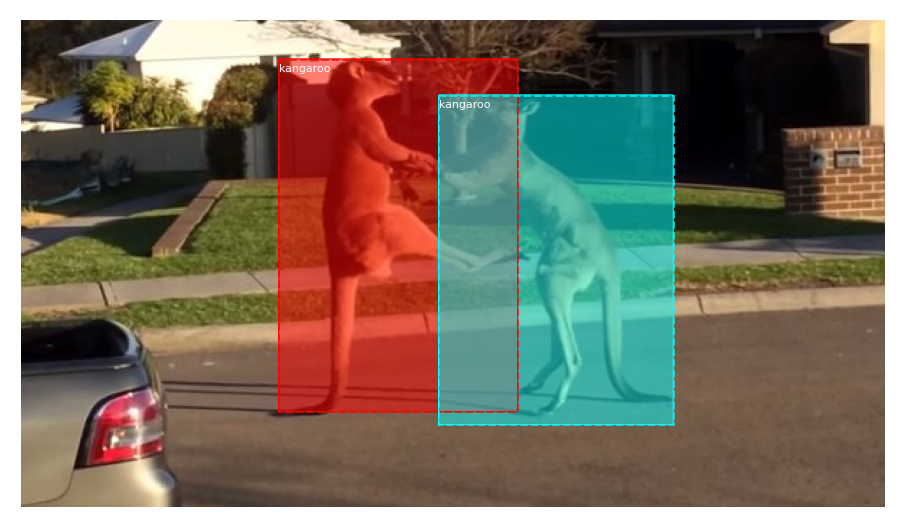

In [18]:
# define image id
image_id = 0
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

## Training Mask R-CNN
Uses Transfer Learning rather than fitting model from scratch. Giving it a pretrained weights allows the model to have a starting point, then it can be tailored to a specfic dataset. The coco dataset is a good starting place for pretrained weights.

In [14]:
config = ImageConfig()
config.display()
# define the model and save training checkpoints in current directory
# load weights (mscoco) and exclude the output layers
# exclude class-specific output layers will be removed so that new output layers can be defined and trained
# train weights (output layers or 'heads')
model = MaskRCNN(mode='training', model_dir='./checkpoints', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Evaluating the Model
The goal is to predict bounding boxes. Performance of an object recognition task is often is evaulated using the mean absolute precision (mAP). Comparing the actual and predicted bounding boxes gives a good estimate of accuracy. Mathematically, it can be calculated by dividing the area of the overlap by the total area of both bounding boxes. Or, the intersection divided by the union, IoU. A perfect IoU is 1. A positive prediction is considered greater than 0.
<br><br>
A mAP above 90% or 95% is a good score

In [19]:
# Create config and define the model
prediction_config = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./predictions', config=prediction_config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [20]:
# Load model weights
model.load_weights('mask_rcnn_image_cfg_0005.h5', by_name=True)

In [21]:
# Evaluate model on train dataset
train_mAP = evaluate_model(train_set, model, prediction_config)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.879


In [23]:
# Evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, prediction_config)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.958


## Detecting Objects in New Images

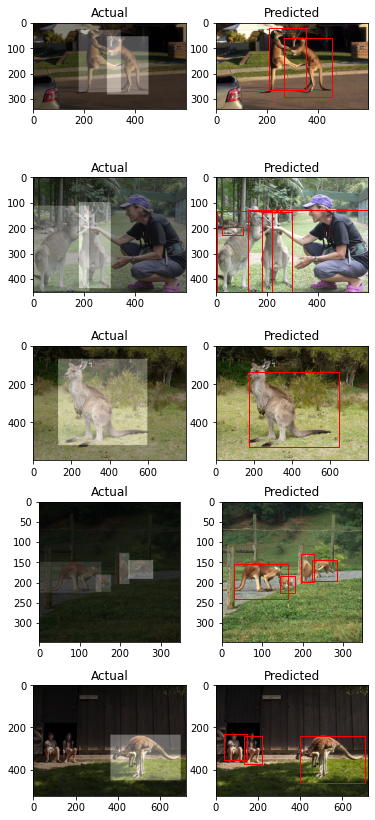

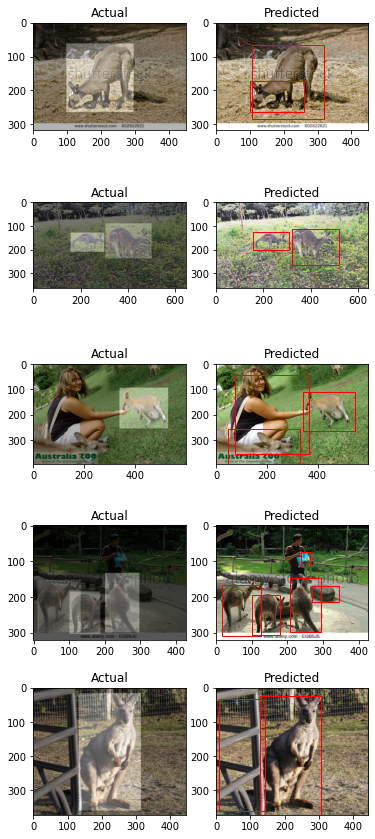

In [32]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, prediction_config)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, prediction_config)